# **Predict Greenhouse Air Temperature using LSTM model**

## **0. Import Libraries**

In [1]:
#=================================================================
# For data processing, plotting, and miscellaneous
#=================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
#plt.style.use('fivethirtyeight')
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import math
import calendar
from datetime import datetime
import datetime
#===================================================================
# Import Keras models, layers, activation functions
#===================================================================
import tensorflow as tf
tf.random.set_seed(3)
import keras
from keras import datasets, models
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, ReLU, Dropout 
from keras import regularizers
from keras import optimizers
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import TimeseriesGenerator
#====================================================================
# From sklearn import required classes
#====================================================================
from sklearn import preprocessing  
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler    
from sklearn.model_selection import train_test_split   
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, root_mean_squared_error

## **1. Import the Dataset**

In [2]:
df_weather = pd.read_csv('Weather.csv')
df_greenhouse = pd.read_csv('GreenhouseClimate.csv',low_memory=False)

print(df_weather.columns)
print(df_greenhouse.columns)

Index(['%time', 'Date', 'AbsHumOut', 'Iglob', 'PARout', 'Pyrgeo', 'RadSum',
       'Rain', 'Rhout', 'Tout', 'Winddir', 'Windsp'],
      dtype='object')
Index(['%time', 'AssimLight', 'BlackScr', 'CO2air', 'Cum_irr', 'EC_drain_PC',
       'EnScr', 'HumDef', 'PipeGrow', 'PipeLow', 'Rhair', 'Tair', 'Tot_PAR',
       'Tot_PAR_Lamps', 'VentLee', 'Ventwind', 'assim_sp', 'assim_vip',
       'co2_dos', 'co2_sp', 'co2_vip', 'dx_sp', 'dx_vip', 'int_blue_sp',
       'int_blue_vip', 'int_farred_sp', 'int_farred_vip', 'int_red_sp',
       'int_red_vip', 'int_white_sp', 'int_white_vip', 'pH_drain_PC',
       'scr_blck_sp', 'scr_blck_vip', 'scr_enrg_sp', 'scr_enrg_vip',
       't_grow_min_sp', 't_grow_min_vip', 't_heat_sp', 't_heat_vip',
       't_rail_min_sp', 't_rail_min_vip', 't_vent_sp', 't_ventlee_vip',
       't_ventwind_vip', 'water_sup', 'water_sup_intervals_sp_min',
       'water_sup_intervals_vip_min', 'window_pos_lee_sp',
       'window_pos_lee_vip'],
      dtype='object')


In [3]:
df_greenhouse = df_greenhouse.astype(float)  # since data was stored as string format, hence convert datatypes to float.

In [4]:
df_initial = pd.concat(
    [
        df_weather["Date"],
        df_greenhouse["Tair"],
        df_weather["Tout"],
        df_greenhouse["Rhair"],
        df_weather["Rhout"],
        df_weather["Iglob"],
        df_weather["Windsp"],
        df_greenhouse["CO2air"]
    ],
    axis=1,
)
print(df_initial.shape)

(47809, 8)


In [5]:
df_initial['Date'] = pd.to_datetime(df_initial['Date'])
df_initial = df_initial.set_axis(df_initial['Date'], copy=False)

In [6]:
df_initial

,Date,Tair,Tout,Rhair,Rhout,Iglob,Windsp,CO2air
Date,,,,,,,,
2019-12-16 00:00:00,2019-12-16 00:00:00,21.0,6.9,51.9,80.6,0.0,4.7,509.0
2019-12-16 00:05:00,2019-12-16 00:05:00,21.5,6.9,51.3,80.6,0.0,4.7,484.0
2019-12-16 00:10:00,2019-12-16 00:10:00,21.6,6.9,52.2,80.4,0.0,4.7,475.0
2019-12-16 00:15:00,2019-12-16 00:15:00,21.3,6.9,54.6,80.2,0.0,4.7,501.0
2019-12-16 00:20:00,2019-12-16 00:20:00,21.4,6.7,54.4,80.9,0.0,4.7,487.0
...,...,...,...,...,...,...,...,...
2020-05-29 23:40:00,2020-05-29 23:40:00,18.0,15.1,86.1,71.4,0.0,4.3,479.0
2020-05-29 23:45:00,2020-05-29 23:45:00,17.9,15.0,86.5,71.5,0.0,4.3,485.0
2020-05-29 23:50:00,2020-05-29 23:50:00,17.9,15.0,86.9,70.8,0.0,3.8,465.0


In [7]:
df_initial.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 47809 entries, 2019-12-16 00:00:00 to 2020-05-30 00:00:00
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    47809 non-null  datetime64[ns]
 1   Tair    47738 non-null  float64       
 2   Tout    47738 non-null  float64       
 3   Rhair   47738 non-null  float64       
 4   Rhout   47738 non-null  float64       
 5   Iglob   47738 non-null  float64       
 6   Windsp  47738 non-null  float64       
 7   CO2air  47738 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 3.3 MB


In [8]:
df_initial.isnull().sum()    # check for null values

Date       0
Tair      71
Tout      71
Rhair     71
Rhout     71
Iglob     71
Windsp    71
CO2air    71
dtype: int64

In [9]:
# ['Tair','Tout','Rhair','Rhout','Iglob','Windsp','CO2air']
# fill the null values with ffill method, can explore other options if required 
#=========================================================================================
df_initial['Tair'].fillna( method ='ffill', inplace = True) 
df_initial['Tout'].fillna( method ='ffill', inplace = True) 
df_initial['Rhair'].fillna( method ='ffill', inplace = True) 
df_initial['Rhout'].fillna( method ='ffill', inplace = True) 
df_initial['Iglob'].fillna( method ='ffill', inplace = True) 
df_initial['Windsp'].fillna( method ='ffill', inplace = True) 
df_initial['CO2air'].fillna( method ='ffill', inplace = True) 

In [10]:
df_initial.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 47809 entries, 2019-12-16 00:00:00 to 2020-05-30 00:00:00
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    47809 non-null  datetime64[ns]
 1   Tair    47809 non-null  float64       
 2   Tout    47809 non-null  float64       
 3   Rhair   47809 non-null  float64       
 4   Rhout   47809 non-null  float64       
 5   Iglob   47809 non-null  float64       
 6   Windsp  47809 non-null  float64       
 7   CO2air  47809 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 3.3 MB


In [11]:
df_initial.isnull().sum()

Date      0
Tair      0
Tout      0
Rhair     0
Rhout     0
Iglob     0
Windsp    0
CO2air    0
dtype: int64

In [12]:
df_initial.tail()

,Date,Tair,Tout,Rhair,Rhout,Iglob,Windsp,CO2air
Date,,,,,,,,
2020-05-29 23:40:00,2020-05-29 23:40:00,18.0,15.1,86.1,71.4,0.0,4.3,479.0
2020-05-29 23:45:00,2020-05-29 23:45:00,17.9,15.0,86.5,71.5,0.0,4.3,485.0
2020-05-29 23:50:00,2020-05-29 23:50:00,17.9,15.0,86.9,70.8,0.0,3.8,465.0
2020-05-29 23:55:00,2020-05-29 23:55:00,17.9,15.0,87.2,71.0,0.0,3.8,470.0
2020-05-30 00:00:00,2020-05-30 00:00:00,17.9,15.0,87.2,71.0,0.0,3.8,470.0


In [13]:
df = df_initial

## **2. Exploratory Data Aanalysis (EDA)**

**Features Description:**

    1) Tair    : Greenhouse Air Temperature
    2) Tout    : Outside Temperature
    3) Rhair   : Greenhouse relative humidity
    4) Rhout   : Outside relative humidity
    5) Iglob   : Solar Radiation
    6) Windsp  : Wind speed
    7) CO2air  : CO2 Greenhouse
   

In [14]:
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
font      = {'family':'arial', 'style':'normal', 'size':18}
axis_font = {'family':'arial', 'style':'normal', 'size':18}
plt.rc('font', **font)

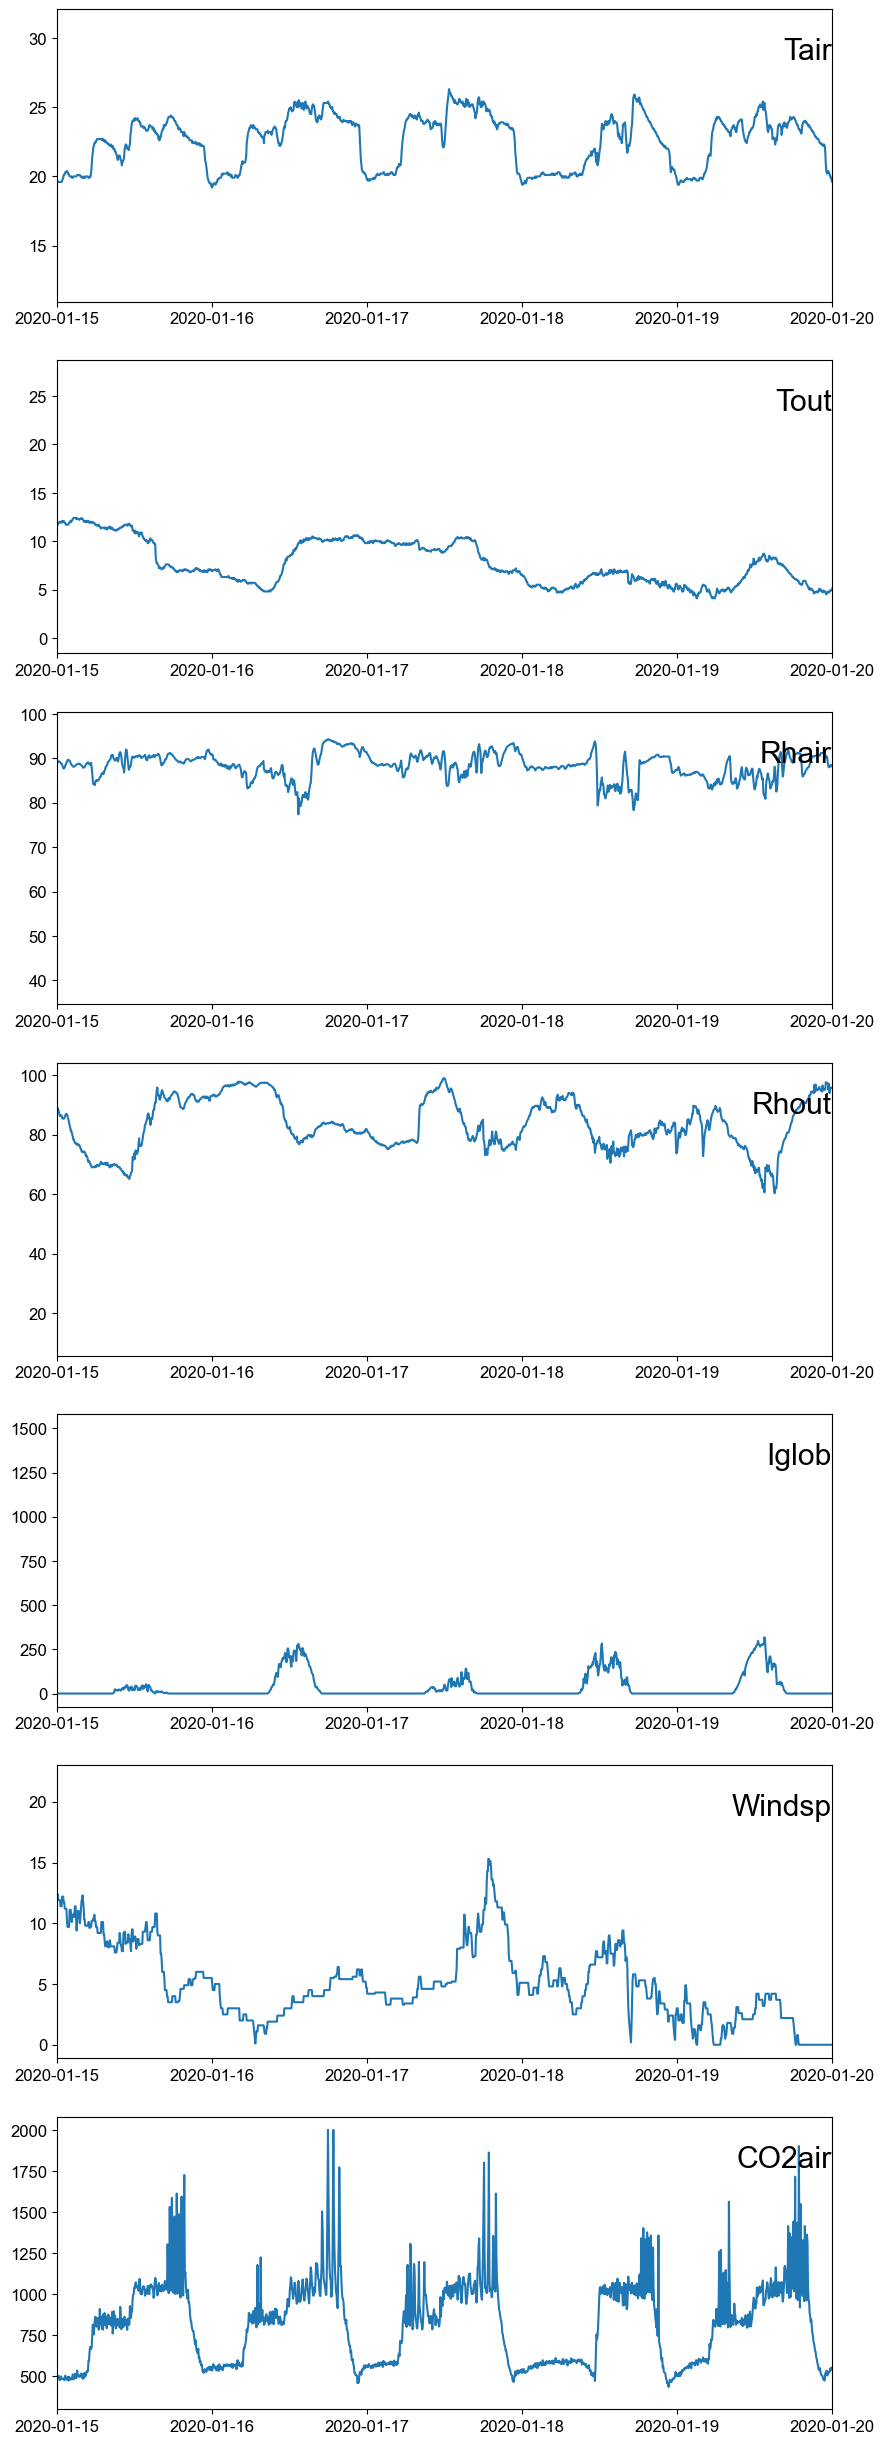

In [15]:
#['Tair','Tout','Rhair','Rhout','Iglob','Windsp',CO2air]]
values = df.values
groups = [1,2,3,4,5,6,7]
i = 1
plt.figure(figsize=(10,3))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.subplots_adjust(top = 18, bottom = 10)   # Adjust the subplot layout parameters.
    plt.plot(df["Date"], values[:,group])
    plt.title(df.columns[group], y=.8, loc='right')
    plt.xlim([datetime.date(2020, 1, 15), datetime.date(2020, 1, 20)])
    i += 1
plt.show()  


### **2.1. Correlation matrix**

In [16]:
df_corr = df_initial[['Tair','Tout','Rhair','Rhout','Iglob','Windsp','CO2air']]
df_corr.head(3)

,Tair,Tout,Rhair,Rhout,Iglob,Windsp,CO2air
Date,,,,,,,
2019-12-16 00:00:00,21.0,6.9,51.9,80.6,0.0,4.7,509.0
2019-12-16 00:05:00,21.5,6.9,51.3,80.6,0.0,4.7,484.0
2019-12-16 00:10:00,21.6,6.9,52.2,80.4,0.0,4.7,475.0


In [17]:
# create cocorrelation matrix
corr_df = df_corr.corr().abs()
#mask = np.triu(np.ones_like(corr_df, dtype=bool))
#tri_df = corr_df.mask(mask)
#tri_df
corr_df

,Tair,Tout,Rhair,Rhout,Iglob,Windsp,CO2air
Tair,1.000000,0.442300,0.456931,0.416492,0.774734,0.112804,0.205957
Tout,0.442300,1.000000,0.383534,0.515896,0.548056,0.084461,0.324466
Rhair,0.456931,0.383534,1.000000,0.328865,0.506958,0.045334,0.209636
Rhout,0.416492,0.515896,0.328865,1.000000,0.623294,0.005647,0.151825
Iglob,0.774734,0.548056,0.506958,0.623294,1.000000,0.052389,0.070992
Windsp,0.112804,0.084461,0.045334,0.005647,0.052389,1.000000,0.071119
CO2air,0.205957,0.324466,0.209636,0.151825,0.070992,0.071119,1.000000


In [18]:
font      = {'family':'arial', 'style':'normal', 'size':14}
axis_font = {'family':'arial', 'style':'normal', 'size':14}
plt.rc('font', **font)

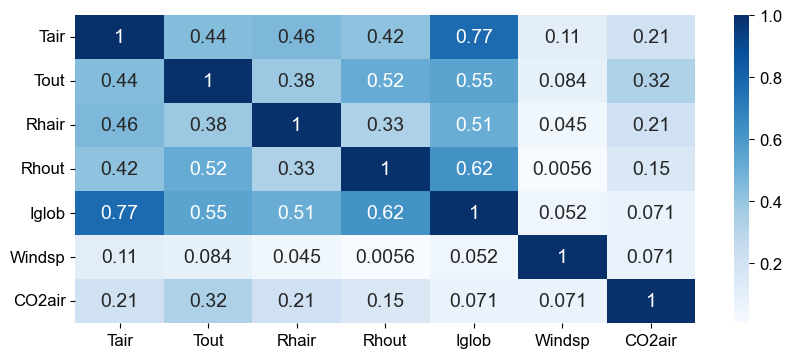

In [19]:
plt.figure(figsize=(10, 4))
sns.heatmap(corr_df, annot=True, cmap='Blues')
plt.show()

**Observations:**

**1) Greenhouse Air temperature (Tair) is having high Correlation (0.77) with Solar Radiation (Iglob) feature, and least correlation (0.11) with Wind speed (Windsp)**

### **2.2. Pair Plots**

In [20]:
#plt.figure(figsize=(12,8))
#sns.pairplot(df_corr)

## **3. Data Preparation**

### **3.1 Creating Training, Validation and Testing sets**

In [21]:
no_prev_timepoints = 8*12*3  # 5min*8*12*3 = 24 hours    # number of previous time points data to be used, to predict the value for the next time point.
train_percent = 0.75       # percentage of data for training
val_percent = 0.15         # percentage of data for validation
# Note : remaining percentage will be used for testing
#=========================================================================================
# copy the selected columns in to a dataframe
df = df_initial[['Tair','Tout','Rhair','Rhout','Iglob','Windsp','CO2air']].values

# copy the date column which will be used later for plotting
df_date = df_initial['Date']
#=========================================================================================

# split the data in to training, validation and testing
train_split = int(len(df)*train_percent)
val_split   = int(len(df)*(train_percent+val_percent))

train_set = df[:train_split]            # training dataset
val_set   = df[train_split:val_split]   # validation dataset
test_set  = df[val_split:]              # testing dataset

val_set_4generator  = df[train_split-no_prev_timepoints:val_split]   # only for timeseries generator, validation dataset 
test_set_4generator = df[val_split-no_prev_timepoints:]             # only for timeseries generator, testing dataset

#=========================================================================================
date_train = df_initial['Date'][:train_split]          # used for plotting. Dates corresponding to training data
date_val = df_initial['Date'][train_split:val_split]   
date_test = df_initial['Date'][val_split:]            

date_val_4generator  = df_initial['Date'][train_split-no_prev_timepoints:val_split]   # used for plotting. Dates corresponding to validation data
date_test_4generator = df_initial['Date'][val_split-no_prev_timepoints:]              

#=========================================================================================
print("Full dataset length   : ", len(df))
print("Training set length   : ", len(train_set))
print("Validation set length : ", len(val_set))
print("Tesing set length     : ", len(test_set))
print(len(val_set_4generator))
print(len(test_set_4generator))
print(len(train_set)+len(val_set)+len(test_set))

Full dataset length   :  47809
Training set length   :  35856
Validation set length :  7172
Tesing set length     :  4781
7460
5069
47809


In [22]:
df_initial.head()

,Date,Tair,Tout,Rhair,Rhout,Iglob,Windsp,CO2air
Date,,,,,,,,
2019-12-16 00:00:00,2019-12-16 00:00:00,21.0,6.9,51.9,80.6,0.0,4.7,509.0
2019-12-16 00:05:00,2019-12-16 00:05:00,21.5,6.9,51.3,80.6,0.0,4.7,484.0
2019-12-16 00:10:00,2019-12-16 00:10:00,21.6,6.9,52.2,80.4,0.0,4.7,475.0
2019-12-16 00:15:00,2019-12-16 00:15:00,21.3,6.9,54.6,80.2,0.0,4.7,501.0
2019-12-16 00:20:00,2019-12-16 00:20:00,21.4,6.7,54.4,80.9,0.0,4.7,487.0


In [23]:
df[:2]

array([[ 21.        ,   6.9       ,  51.9       ,  80.6       ,
          0.        ,   4.7       , 509.        ],
       [ 21.5       ,   6.9       ,  51.3       ,  80.59999999,
          0.        ,   4.7       , 484.        ]])

In [24]:
df[train_split:train_split+2]

array([[ 27.        ,  12.70000005,  83.5       ,  53.40000005,
        283.0000026 ,   3.2       , 812.        ],
       [ 27.1       ,  13.19999995,  85.        ,  53.89999995,
        308.9999974 ,   3.2       , 802.        ]])

In [25]:
val_set[:2]

array([[ 27.        ,  12.70000005,  83.5       ,  53.40000005,
        283.0000026 ,   3.2       , 812.        ],
       [ 27.1       ,  13.19999995,  85.        ,  53.89999995,
        308.9999974 ,   3.2       , 802.        ]])

In [26]:
df[-3:]

array([[ 17.9       ,  15.        ,  86.9       ,  70.80000002,
          0.        ,   3.80000002, 465.        ],
       [ 17.9       ,  14.99999999,  87.2       ,  71.00000001,
          0.        ,   3.8       , 470.        ],
       [ 17.9       ,  14.99999999,  87.2       ,  71.00000001,
          0.        ,   3.8       , 470.        ]])

In [27]:
test_set[-3:]

array([[ 17.9       ,  15.        ,  86.9       ,  70.80000002,
          0.        ,   3.80000002, 465.        ],
       [ 17.9       ,  14.99999999,  87.2       ,  71.00000001,
          0.        ,   3.8       , 470.        ],
       [ 17.9       ,  14.99999999,  87.2       ,  71.00000001,
          0.        ,   3.8       , 470.        ]])

### **3.2. Visualize the Data**

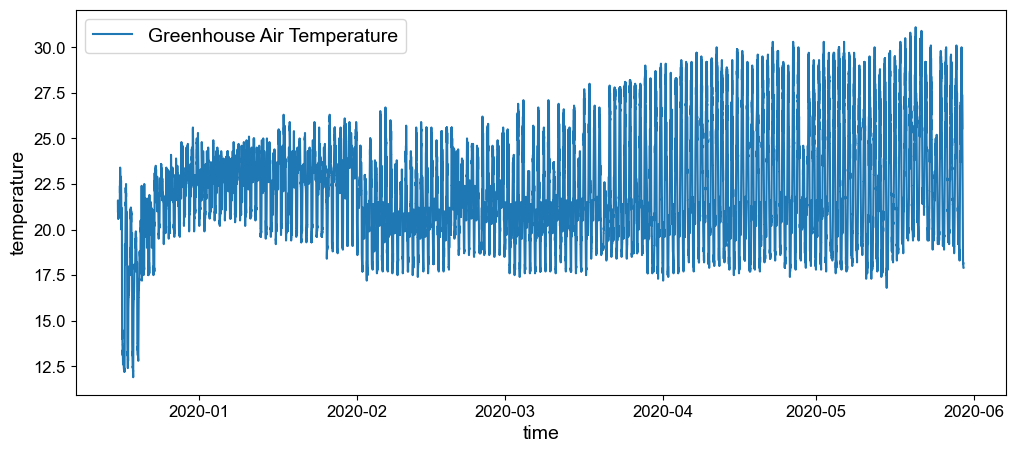

In [28]:
# 1) Tair    : Greenhouse Air Temperature
#===========================================================================
fig = plt.figure(figsize=(12, 5))
plt.plot(df_initial["Date"], df_initial["Tair"], label='Greenhouse Air Temperature')
plt.xlabel("time", axis_font)
plt.ylabel("temperature", axis_font)
plt.legend()
plt.show()

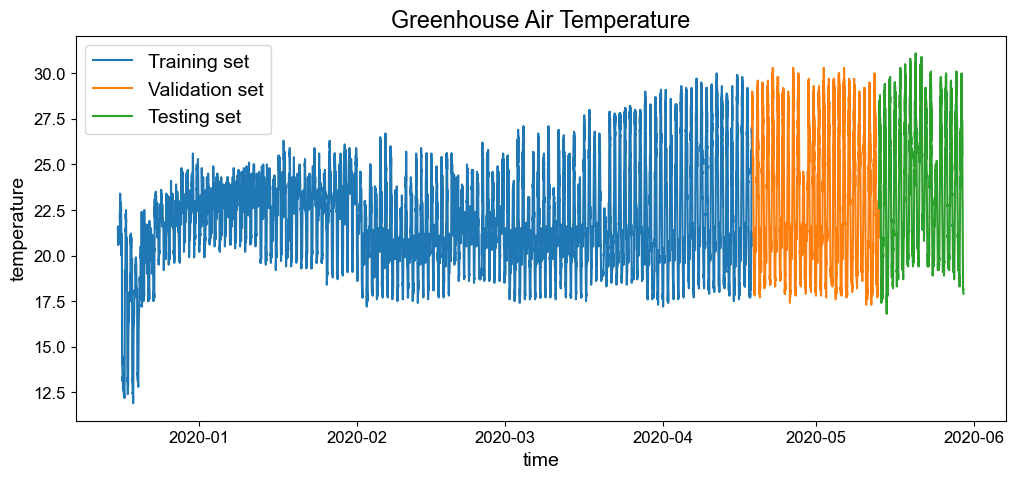

In [29]:
# 1) Tair    : Greenhouse Air Temperature
#===========================================================================
fig = plt.figure(figsize=(12, 5))
plt.plot(date_train,train_set[:, 0], label='Training set')
plt.plot(date_val,val_set[:, 0], label='Validation set')
plt.plot(date_test,test_set[:, 0], label='Testing set')
plt.title('Greenhouse Air Temperature')
plt.xlabel("time", axis_font)
plt.ylabel("temperature", axis_font)
#plt.xlim([datetime.date(2020, 4, 15), datetime.date(2020, 5, 20)])
plt.legend()
plt.show()

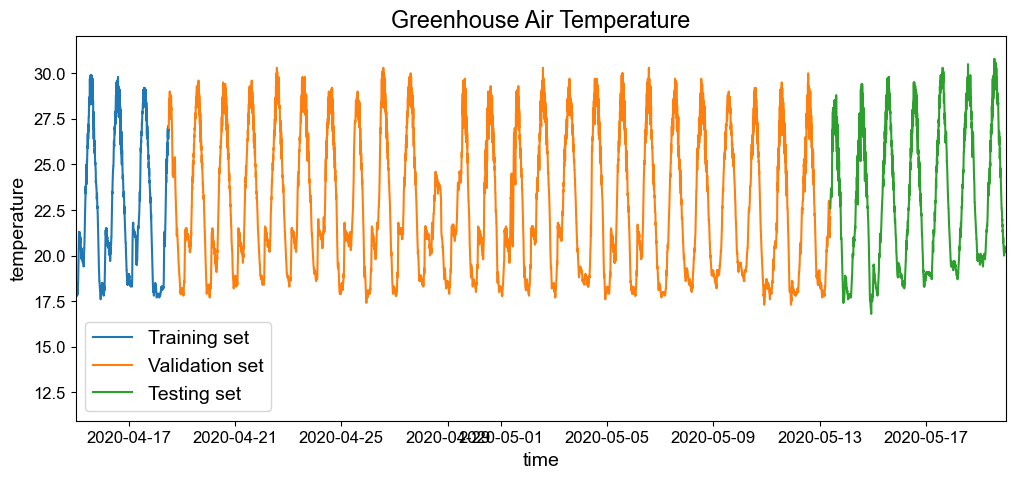

In [30]:
# 1) Tair    : Greenhouse Air Temperature
#===========================================================================
fig = plt.figure(figsize=(12, 5))
plt.plot(date_train,train_set[:, 0], label='Training set')
plt.plot(date_val,val_set[:, 0], label='Validation set')
plt.plot(date_test,test_set[:, 0], label='Testing set')
plt.title('Greenhouse Air Temperature')
plt.xlabel("time", axis_font)
plt.ylabel("temperature", axis_font)
plt.xlim([datetime.date(2020, 4, 15), datetime.date(2020, 5, 20)])
plt.legend()
plt.show()

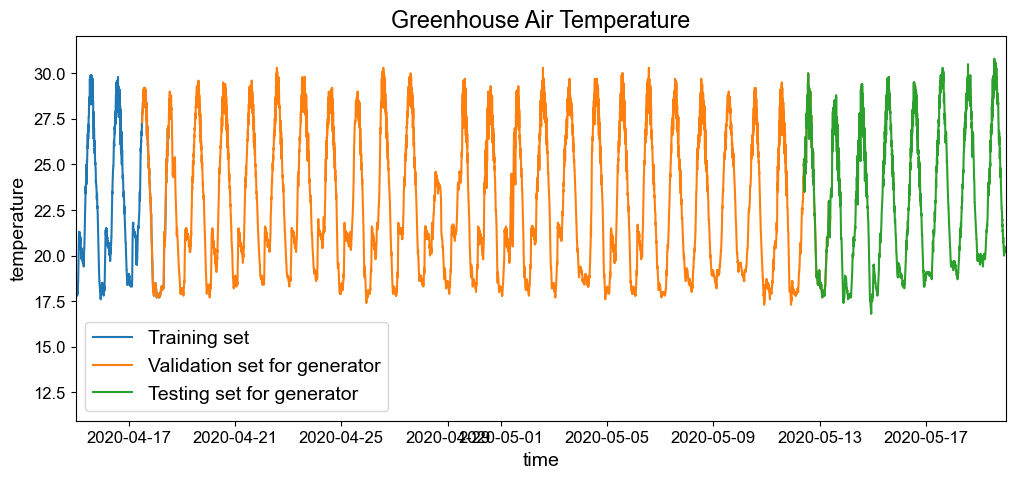

In [31]:
# Plot train, validation and test sets
#===========================================================================
plt.figure(figsize=(12,5))
plt.plot(date_train,train_set[:,0], label='Training set')
plt.plot(date_val_4generator,val_set_4generator[:,0], label='Validation set for generator')
plt.plot(date_test_4generator,test_set_4generator[:,0], label='Testing set for generator')
plt.title('Greenhouse Air Temperature')
plt.xlabel("time", axis_font)
plt.ylabel("temperature", axis_font)
plt.xlim([datetime.date(2020, 4, 15), datetime.date(2020, 5, 20)])
plt.legend()
plt.show()

### **3.3. Normalize the Data**

In [32]:
# Fit and Transform training set 
X_scaler = MinMaxScaler(feature_range=(0,1))
#X_scaler = StandardScaler()
train_set_scaled = X_scaler.fit_transform(train_set)
#===========================================================================
# Transform validation and testing sets 
val_set_scaled = X_scaler.transform(val_set_4generator)
test_set_scaled = X_scaler.transform(test_set_4generator)

In [33]:
train_set_scaled.shape, val_set_scaled.shape, test_set_scaled.shape

((35856, 7), (7460, 7), (5069, 7))

In [34]:
train_set[:2]

array([[ 21.        ,   6.9       ,  51.9       ,  80.6       ,
          0.        ,   4.7       , 509.        ],
       [ 21.5       ,   6.9       ,  51.3       ,  80.59999999,
          0.        ,   4.7       , 484.        ]])

In [35]:
train_set_scaled[:2]

array([[0.50276243, 0.29218107, 0.01298701, 0.78683035, 0.        ,
        0.21461187, 0.07160648],
       [0.53038674, 0.29218107, 0.        , 0.78683035, 0.        ,
        0.21461187, 0.05603985]])

In [36]:
val_set[:2]

array([[ 27.        ,  12.70000005,  83.5       ,  53.40000005,
        283.0000026 ,   3.2       , 812.        ],
       [ 27.1       ,  13.19999995,  85.        ,  53.89999995,
        308.9999974 ,   3.2       , 802.        ]])

In [37]:
val_set_scaled[:2]

array([[0.85082873, 0.48148148, 0.66017316, 0.51004463, 0.87817259,
        0.28310502, 0.25280199],
       [0.86740331, 0.50617284, 0.66017316, 0.4955357 , 0.88451777,
        0.26027398, 0.23536737]])

In [38]:
test_set[:2]

array([[ 22.6       ,   8.9       ,  83.7       ,  77.59999999,
        253.0000005 ,   4.6       , 893.        ],
       [ 22.8       ,   8.90000003,  84.2       ,  77.29999987,
        269.000005  ,   4.60000005, 864.        ]])

In [39]:
test_set_scaled[:2]

array([[0.72375691, 0.35390947, 0.4978355 , 0.52455356, 0.7068528 ,
        0.14611872, 0.22851806],
       [0.71823204, 0.39506173, 0.43939394, 0.5424107 , 0.75380712,
        0.14611872, 0.24595268]])

### **3.4. Define TimeseriesGenerator for training, validation and testing sets**

Source : https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/TimeseriesGenerator

* here previous *no_prev_timepoints* (the number of previous timepoints’ data to use) are used to predict the value for the next timepoint.
* need *no_prev_timepoints* before the 1st date in the validation or test dataset.
* Accordingly, create input for validation prediciton and testing prediction, index starting from the date *no_prev_timepoints* days before the first date in the validation or test dataset.

In [40]:
batchsize = 64

train_generator = TimeseriesGenerator(train_set_scaled, train_set_scaled[:,0], length=no_prev_timepoints, batch_size=batchsize)     
val_generator = TimeseriesGenerator(val_set_scaled, val_set_scaled[:,0], length=no_prev_timepoints, batch_size=batchsize)     
test_generator  = TimeseriesGenerator(test_set_scaled, test_set_scaled[:,0], length=no_prev_timepoints, batch_size=batchsize)

In [41]:
#train_set_scaled[:7]

In [42]:
#train_generator[0]

In [43]:
#train_generator[0]   # 1st sample , since batch_size = 1, hence one sample at a time

In [44]:
#val_set_scaled[:2]

In [45]:
#val_generator[0]        

In [46]:
#test_set_scaled[:15]

In [47]:
#test_generator[0]     

## **4. Build RNN - LSTM Model**

### **4.1. Create LSTM Model**

In [48]:
model = Sequential() 
num_features = train_set_scaled.shape[1]
#===========================================================================
#1st LSTM layer
model.add(LSTM(units=16, input_shape = (no_prev_timepoints, num_features) , return_sequences=False, activation='tanh', name='LSTM_1'))

# Output layer
model.add(Dense(1, name='Output')) 

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_1 (LSTM)               (None, 16)                1536      
                                                                 
 Output (Dense)              (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________


### **4.2. Compile the model**

In [49]:
model.compile(optimizer='adam', loss='mean_squared_error')

### **4.3. Train the Model**

In [50]:
num_epochs = 10

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=3)

training = model.fit(train_generator, validation_data=test_generator, epochs=num_epochs, shuffle=False, callbacks=[early_stopping])
#training = model.fit(train_generator, validation_data=test_generator, epochs=num_epochs)

Epoch 1/10
556/556 [==============================] - 12s 17ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 2/10
556/556 [==============================] - 9s 16ms/step - loss: 7.4570e-04 - val_loss: 9.1449e-04
Epoch 3/10
556/556 [==============================] - 9s 16ms/step - loss: 5.0569e-04 - val_loss: 6.9389e-04
Epoch 4/10
556/556 [==============================] - 9s 16ms/step - loss: 3.9260e-04 - val_loss: 6.1290e-04
Epoch 5/10
556/556 [==============================] - 9s 17ms/step - loss: 3.2569e-04 - val_loss: 6.7185e-04
Epoch 6/10
556/556 [==============================] - 9s 16ms/step - loss: 2.9428e-04 - val_loss: 7.1731e-04
Epoch 7/10
556/556 [==============================] - 9s 16ms/step - loss: 2.7155e-04 - val_loss: 7.1595e-04


### **4.4. Plot the Loss history**

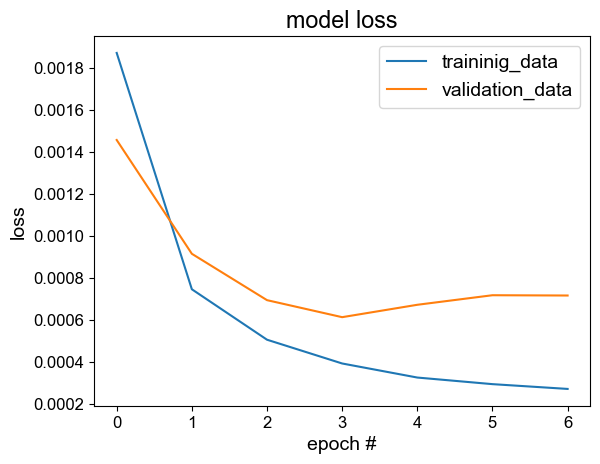

In [51]:
plt.plot(training.history['loss'], label='traininig_data')
plt.plot(training.history['val_loss'], label='validation_data')
plt.legend()
plt.title("model loss")
plt.xlabel("epoch #")
plt.ylabel("loss")
plt.show()

In [52]:
type(date_train)

pandas.core.series.Series

In [53]:
type(train_set)

numpy.ndarray

In [54]:
type(val_set)

numpy.ndarray

In [55]:
type(test_set)

numpy.ndarray

In [56]:
train_set.shape

(35856, 7)

### **4.5. Prediction for Validation and Test Ddata**

In [57]:
train_set_plot = X_scaler.inverse_transform(train_set_scaled)
train_set_plot = train_set_plot[no_prev_timepoints:]

date_train_plot = date_train[no_prev_timepoints:]

In [58]:
train_set_plot[:2]

array([[ 12.6       ,   6.9       ,  82.        ,  99.5       ,
          0.        ,   1.5       , 521.        ],
       [ 12.6       ,   6.99999999,  81.7       ,  99.5       ,
          0.        ,   2.        , 522.        ]])

In [59]:
date_train_plot[:5]

Date
2019-12-17 00:00:00   2019-12-17 00:00:00
2019-12-17 00:05:00   2019-12-17 00:05:00
2019-12-17 00:10:00   2019-12-17 00:10:00
2019-12-17 00:15:00   2019-12-17 00:15:00
2019-12-17 00:20:00   2019-12-17 00:20:00
Name: Date, dtype: datetime64[ns]

In [60]:
train_predict = model.predict(train_generator)
test_predict = model.predict(test_generator)
val_predict = model.predict(val_generator)

113/113 [==============================] - 1s 8ms/step


In [61]:
train_predict

array([[0.05278916],
       [0.05074697],
       [0.05012922],
       ...,
       [0.7848725 ],
       [0.77890766],
       [0.7803834 ]], dtype=float32)

In [62]:
# Perform inverse transformation to rescale back to original range
# Since 7 variables were used for transform, the inverse expects same dimensions
# Therefore, copy values 7 times and discard them after inverse transform
#=============================================================================================
train_predict = np.repeat(train_predict, num_features, axis=-1)
train_predict = X_scaler.inverse_transform(train_predict)[:,0]

val_predict = np.repeat(val_predict, num_features, axis=-1)
val_predict = X_scaler.inverse_transform(val_predict)[:,0]

test_predict = np.repeat(test_predict, num_features, axis=-1)
test_predict = X_scaler.inverse_transform(test_predict)[:,0]

In [63]:
train_predict  = train_predict.reshape((-1))
val_predict  = val_predict.reshape((-1))
test_predict  = test_predict.reshape((-1))

In [64]:
date_train_plot.shape, train_set_plot.shape, train_predict.shape

((35568,), (35568, 7), (35568,))

In [65]:
date_val.shape, val_set.shape, val_predict.shape

((7172,), (7172, 7), (7172,))

In [66]:
date_test.shape, test_set.shape, test_predict.shape

((4781,), (4781, 7), (4781,))

### **4.6. Model Evaluation Metrics**

In [79]:
#===========================================================================
# 1. R-Square
#===========================================================================
R2_train = round(r2_score(train_set_plot[:, 0],train_predict),4)
R2_val   = round(r2_score(val_set[:, 0],val_predict),4)
R2_test  = round(r2_score(test_set[:, 0],test_predict),4)

print("="*70)
print("R^2 (coefficient of determination) regression score:")
print(" ")
print("Training set   = ",R2_train)
print(" ")
print("Validation set = ",R2_val)
print(" ")
print("Testing set    = ",R2_test)
print("="*70)
print(" ")

#===========================================================================
# 2. Root Mean Squared Error
#===========================================================================                          
#mse_train = mean_squared_error(train_set_plot[:, 0],train_predict)
#mse_val   = mean_squared_error(val_set[:, 0],val_predict)
#mse_test  = mean_squared_error(test_set[:, 0],test_predict)

rmse_train = round(root_mean_squared_error(train_set_plot[:, 0],train_predict),4)
rmse_val   = round(root_mean_squared_error(val_set[:, 0],val_predict),4)
rmse_test  = round(root_mean_squared_error(test_set[:, 0],test_predict),4)

print("Root Mean Squared Error:")
print(" ")
print("Training set    = ",rmse_train)
print(" ")
print("Validation set  = ",rmse_val)
print(" ")
print("Testing set     = ",rmse_test)
print("="*70)

##===========================================================================
## 3. Coefficient of Variation of the Root Mean Squared Error (CV(RMSE))
##===========================================================================   
#cvrmse_train = round(100*rmse_train/np.mean(train_set_plot[:, 0]),1)
#cvrmse_val   = round(100*rmse_val/np.mean(val_set[:, 0]),1)
#cvrmse_test  = round(100*rmse_test/np.mean(test_set[:, 0]),1)

#print("Coefficient of Variation of the Root Mean Squared Error (CV(RMSE)):")
#print(" ")
#print("Training set    = ",cvrmse_train)
#print(" ")
#print("Validation set  = ",cvrmse_val)
#print(" ")
#print("Testing set     = ",cvrmse_test)
#print("="*70)

R^2 (coefficient of determination) regression score:
 
Training set   =  0.9796
 
Validation set =  0.9858
 
Testing set    =  0.982
 
Root Mean Squared Error:
 
Training set    =  0.3794
 
Validation set  =  0.4356
 
Testing set     =  0.4843


In [68]:
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
font      = {'family':'arial', 'style':'normal', 'size':18}
axis_font = {'family':'arial', 'style':'normal', 'size':18}
plt.rc('font', **font)

### **4.7. Visualize the predictions**

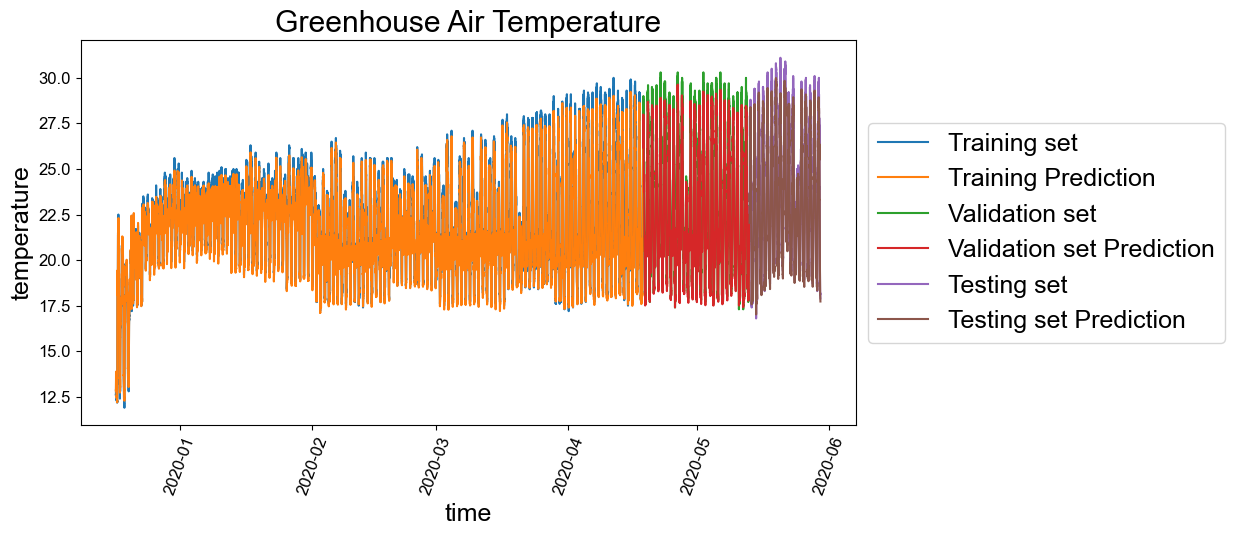

In [69]:
# 1) Tair    : Greenhouse Air Temperature
#===========================================================================
fig = plt.figure(figsize=(10, 5))
plt.plot(date_train_plot,train_set_plot[:, 0], label='Training set')
plt.plot(date_train_plot,train_predict, label='Training Prediction')
plt.plot(date_val,val_set[:, 0], label='Validation set')
plt.plot(date_val,val_predict, label='Validation set Prediction')
plt.plot(date_test,test_set[:, 0], label='Testing set')
plt.plot(date_test,test_predict, label='Testing set Prediction')
plt.title('Greenhouse Air Temperature')
plt.xlabel("time", axis_font)
plt.ylabel("temperature", axis_font)
#plt.xlim([datetime.date(2020, 4, 15), datetime.date(2020, 5, 15)])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=70)
#plt.legend()
plt.show()

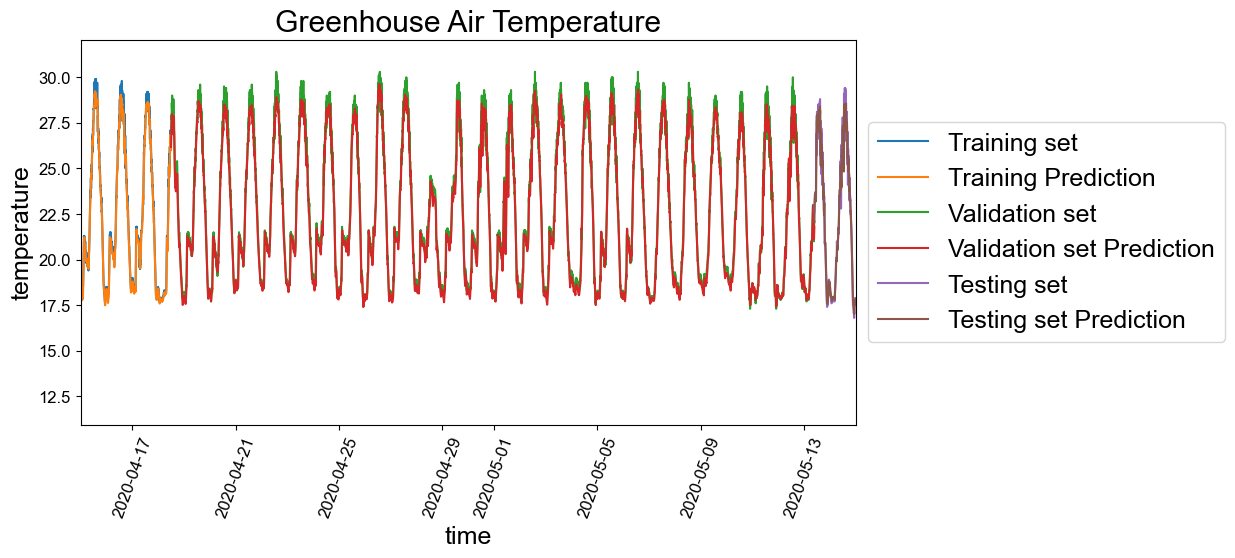

In [70]:
# 1) Tair    : Greenhouse Air Temperature
#===========================================================================
fig = plt.figure(figsize=(10, 5))
plt.plot(date_train_plot,train_set_plot[:, 0], label='Training set')
plt.plot(date_train_plot,train_predict, label='Training Prediction')
plt.plot(date_val,val_set[:, 0], label='Validation set')
plt.plot(date_val,val_predict, label='Validation set Prediction')
plt.plot(date_test,test_set[:, 0], label='Testing set')
plt.plot(date_test,test_predict, label='Testing set Prediction')
plt.title('Greenhouse Air Temperature')
plt.xlabel("time", axis_font)
plt.ylabel("temperature", axis_font)
plt.xlim([datetime.date(2020, 4, 15), datetime.date(2020, 5, 15)])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=70)
#plt.legend()
plt.show()

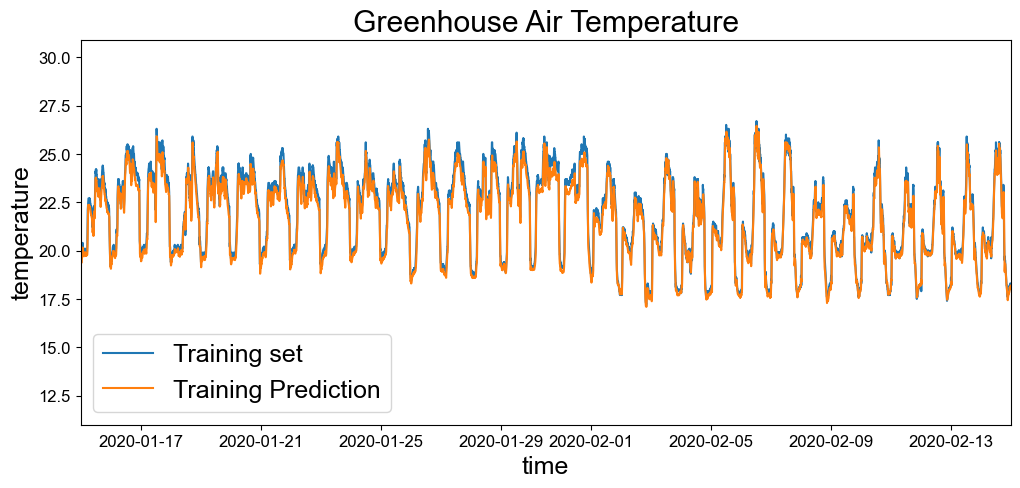

In [71]:
# 1) Tair    : Greenhouse Air Temperature
#===========================================================================
fig = plt.figure(figsize=(12, 5))
plt.plot(date_train_plot,train_set_plot[:, 0], label='Training set')
plt.plot(date_train_plot,train_predict, label='Training Prediction')
plt.title('Greenhouse Air Temperature')
plt.xlabel("time", axis_font)
plt.ylabel("temperature", axis_font)
plt.xlim([datetime.date(2020, 1, 15), datetime.date(2020, 2, 15)])
#plt.ylim(16,28)
plt.legend()
plt.show()

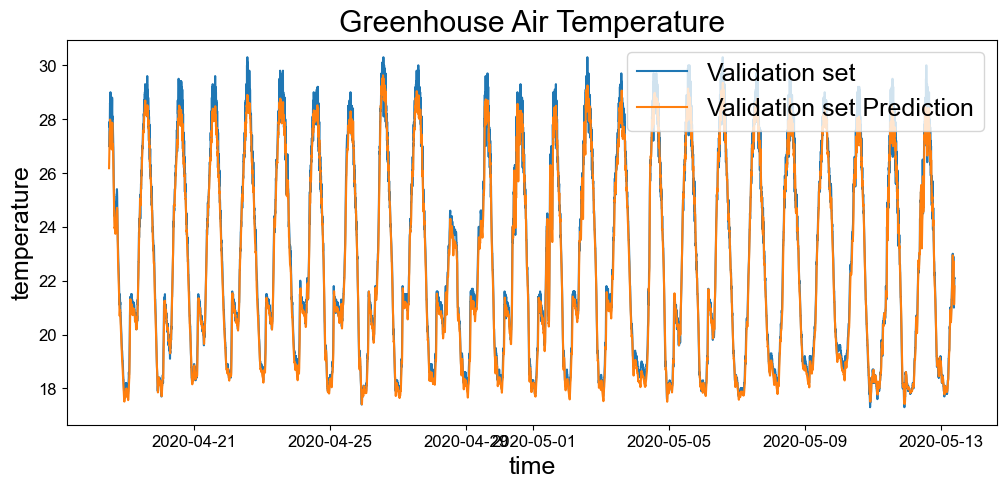

In [72]:
# 1) Tair    : Greenhouse Air Temperature
#===========================================================================
fig = plt.figure(figsize=(12, 5))
plt.plot(date_val,val_set[:, 0], label='Validation set')
plt.plot(date_val,val_predict, label='Validation set Prediction')
plt.title('Greenhouse Air Temperature')
plt.xlabel("time", axis_font)
plt.ylabel("temperature", axis_font)
plt.legend()
plt.show()

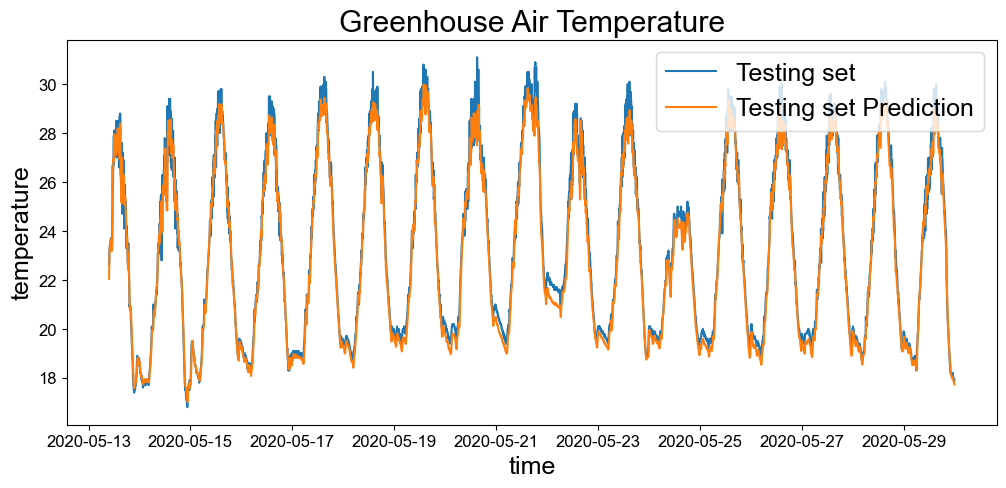

In [73]:
# 1) Tair    : Greenhouse Air Temperature
#===========================================================================
fig = plt.figure(figsize=(12, 5))
plt.plot(date_test,test_set[:, 0], label='Testing set')
plt.plot(date_test,test_predict, label='Testing set Prediction')
plt.title('Greenhouse Air Temperature')
plt.xlabel("time", axis_font)
plt.ylabel("temperature", axis_font)
#plt.xlim([datetime.date(2020, 1, 15), datetime.date(2020, 2, 15)])
plt.legend()
plt.show()

## **5. Save the Trained model**

In [74]:
model.save("DL_LSTM_Timeseries_Temperature_Prediction_v1.h5")

## **END**